# Coopetition of Danish banks

This notebook contains a simple model to verify the data.

## Step 1. Load KPI spreadsheet from Finanstilsynet

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# PI_D is a hidden sheet that contains the data for pivot tables PI_A & PI_B
kpis = pd.read_excel(io="data/KPI_Penge_fonds_Real_202412.xlsx", sheet_name="PI_D")
kpis.rename(columns={"vaerdi": "value",
                   "År (Year)": "year",
                   "Vælg nøgletal (Choose KPI)": "kpi",
                   "Virksomhedsnavn (Company Name)": "bank"
                   }, inplace=True)
kpis.drop(columns=["Vælg niveau (Choose Company Level)",
                 "Vælg virksomhedsgruppering (Choose Company Grouping)",
                 "ITYPE"], inplace=True)
kpi_map = {
    "Solvensprocent (Solvency ratio)": "solvency_ratio",
    "Kernekapitalprocent (Tier 1 capital ratio)": "tier1_cap",
    "Egenkapitalforrentning før skat (Return on equity before tax)": "roe_pre_tax",
    "Egenkapitalforrentning efter skat (Return on equity after tax)": "roe_post_tax",
    "Indtjening pr. omkostningskrone (Income/cost ratio)": "cost_to_income",
    "Renterisiko (Interest rate risk)": "interest_rate_risk",
    "Valutaposition (Foreign exchange position)": "fx_position",
    "Valutarisiko (Foreign exchange risk)": "fx_risk",
    "Udlån plus nedskrivninger herpå i forhold til indlån (Loans and impairment losses over deposits)": "loans_over_deposits",
    "Overdækning i forhold til lovkrav om likviditet (Excess coverage as a percentage of the liquidity requirement)": "liq_coverage",
    "Summen af store eksponeringer (Sum of large exposures)": "large_exposures",
    "Årets nedskrivningsprocent (Annual impairment ratio)": "impairment_ratio",
    "Årets udlånsvækst (Growth in loans)": "loan_growth",
    "Udlån i forhold til egenkapital (Gearing)": "gearing",
    "Årets resultat pr. aktie (stykstørrelse 100 kr.) (Annual earnings per share (nominal value DKK 100) before tax)": "eps_pre_tax",
    "Årets resultat pr. aktie (stykstørrelse 100 kr.) (Annual earnings per share (nominal value DKK 100) after tax)": "eps_post_tax",
    "Indre værdi pr. aktie (stykstørrelse 100 kr.)(Book value over net asset value)": "book_value_per_share",
    "Børskurs/resultat pr. aktie (stykstørrelse 100 kr.) (Price over net asset value (nominal value DKK 100))": "price_over_nav",
    "Børskurs/indre værdi pr. aktie (stykstørrelse 100 kr.) (Price over book value (nominal value DKK100))": "price_over_book"
}
kpis["kpi"] = kpis["kpi"].map(kpi_map)


## Step 2. Add datacentral information

In [2]:
platforms = pd.read_excel("data/BankByDC.xlsx")
kpis_platforms = kpis.merge(platforms, on="bank", how="left")
# some banks are missing datacentral information - those are not interesting for further analysis
kpis_platforms = kpis_platforms.dropna(subset=["dc"])

## Step 3. From long to wide format

In [3]:
df_wide = kpis_platforms.pivot_table(index=["bank", "year", "dc", "REGNR"], columns="kpi", values="value").reset_index()

## Step 4. Add total assets
PI_regnskaber_2000_2024.xlsx is another spreadsheet from Finanstilsynet that contains balance sheets for the banks. Due to the change in reporting forms across the years, getting the data requires more effort here. We will be using only total assets value (Aktiver i alt) for the models. Their value is in fields:
* FB0214
* AS0222
* Bal_BO_ATot

For further calculation, we will be using logarithmized value.

In [4]:
# Data_FB is a sheet that contains data for 2000-2004 period
balance_00_04 = pd.read_excel(io="data/PI_regnskaber_2000_2024.xlsx", sheet_name="Data_FB")
balance_00_04["year"] = balance_00_04["REGNPER"] // 100
balance_00_04.rename(columns={"FB0214": "total_assets"}, inplace=True)

# Data_AS is a sheet that contains data for 2005-2015 period
balance_05_15 = pd.read_excel(io="data/PI_regnskaber_2000_2024.xlsx", sheet_name="Data_AS")
balance_05_15["year"] = balance_05_15["REGNPER"] // 100
balance_05_15.rename(columns={"AS0222": "total_assets"}, inplace=True)

# Data_KRGS is a sheet that contains data for 2016-2024 period
balance_16_24 = pd.read_excel(io="data/PI_regnskaber_2000_2024.xlsx", sheet_name="Data_KRGS")
balance_16_24["year"] = balance_16_24["ref_date"] // 100
balance_16_24.rename(columns={"regnr": "REGNR", "Bal_BO_ATot": "total_assets"}, inplace=True)

balance_all = pd.concat(
    [balance_00_04, balance_05_15, balance_16_24],
    ignore_index=True
)

df_wide_balance = df_wide.merge(
    balance_all[["REGNR", "total_assets", "year"]],
    on=["REGNR", "year"],
    how="left"
)

df_wide_balance["log_total_assets"] = np.log(df_wide_balance["total_assets"])

## Step 6. Dummies for DCs
Banks can be on one of three datacentrals: BEC, Netcompany Banking Services (NBS) or Bankdata. They can also be a datacentral for themselves, but we ignore those as outliers.

In [5]:
df_dummies = df_wide_balance.loc[df_wide_balance["dc"] != "OWN"].copy()
df_dummies["dc"] = pd.Categorical(
    df_dummies["dc"],
    categories=["BEC", "NBS", "Bankdata"],
    ordered=True
)

# BEC is the baseline
df_dummies = pd.get_dummies(df_dummies, columns=["dc"], drop_first=True, dtype=int)


## Step 7. Basic data analysis

Based on Dreyer (2018) and our own experience, we pick the following variables from our dataset:

* cost_to_income (dependent variable)
* dc_NBS (dummy for datacentral)
* dc_Bankdata (dummy for datacentral)
* log_total_assets (as in Dreyer (2018))
* tier1_cap (as in Dreyer (2018))
* loan_growth
* gearing (as in Dreyer (2018), where it is called leverage ratio)
* loans_over_deposits (similar to DA in Dreyer (2018))

Let's check the quality of those.


In [6]:
df_short = df_dummies[["cost_to_income", "dc_NBS", "dc_Bankdata", "log_total_assets", "tier1_cap", "loan_growth", "gearing", "loans_over_deposits", "year", "bank"]].copy()
for col in df_short:
    pct_missing = np.mean(df_short[col].isnull())
    print(col, '\t', pct_missing * 100, '%')

cost_to_income 	 0.0 %
dc_NBS 	 0.0 %
dc_Bankdata 	 0.0 %
log_total_assets 	 0.0 %
tier1_cap 	 0.0 %
loan_growth 	 0.28116213683223995 %
gearing 	 0.28116213683223995 %
loans_over_deposits 	 0.18744142455482662 %
year 	 0.0 %
bank 	 0.0 %


In [7]:
# basic cleaning - drop NaN rows
df_clean = df_short.dropna()

# TODO: histograms, outliers removal...

## Step 8. Simple model
cost-to-income on various DCs in 2024

In [8]:
# let's focus only on 2024
df_2024 = df_clean[df_clean["year"] == 2024].copy()

y = df_2024["cost_to_income"]
X = df_2024[["tier1_cap", "loan_growth", "gearing", "loans_over_deposits", "dc_NBS", "dc_Bankdata", "log_total_assets"]]
X = sm.add_constant(X)

# Used robust standard errors (HC3) to account for heteroskedasticity
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         cost_to_income   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     2.263
Date:                Sun, 21 Dec 2025   Prob (F-statistic):             0.0513
Time:                        21:30:26   Log-Likelihood:                -13.574
No. Observations:                  44   AIC:                             43.15
Df Residuals:                      36   BIC:                             57.42
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1608    

We're surprised by relatively high R<sup>2</sup> given the low number of samples (44). With a little bit of tweaking, we can get p-value even lower, so we can reject H0.
tier1_cap turned out to be nonsignificant. This is in contrast with Dreyer (2018). We need to take a closer look at the data here.
so is loan_growth and gearing...
log_total_assets: non-intuitive result, which suggest that bigger banks have higher c/i (while we should have economies of scale).

dc_NBS: no difference vs baseline (BEC): makes sense based on nature of those two companies
dc_Bankdata: banks using Bankdata have higher cost-to-income

residuals far from normal

## Step 9. PooledOLS
In PooledOLS we assume that each bank in each year is a new observation.

                          PooledOLS Estimation Summary                          
Dep. Variable:         cost_to_income   R-squared:                        0.1147
Estimator:                  PooledOLS   R-squared (Between):              0.3427
No. Observations:                1063   R-squared (Within):               0.0745
Date:                Sun, Dec 21 2025   R-squared (Overall):              0.1147
Time:                        21:30:31   Log-likelihood                   -821.79
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      19.529
Entities:                          52   P-value                           0.0000
Avg Obs:                       20.442   Distribution:                  F(7,1055)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             14.405
                            

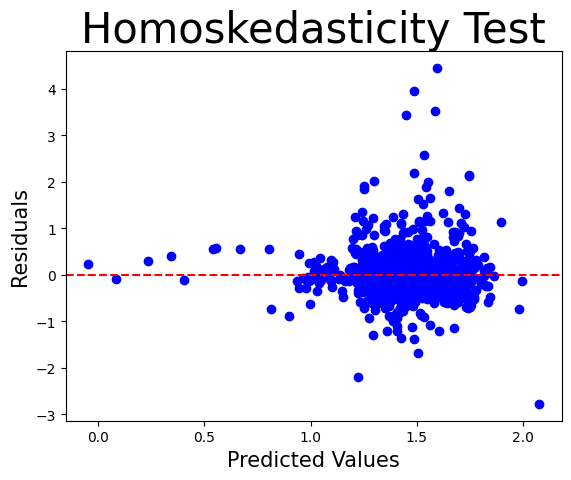

In [9]:
from linearmodels.panel import PooledOLS

df_panel = df_clean.set_index(["bank", "year"]).sort_index()

y_pooled = df_panel["cost_to_income"]
X_pooled = df_panel[["tier1_cap", "loan_growth", "gearing", "loans_over_deposits", "dc_NBS", "dc_Bankdata", "log_total_assets"]]
X_pooled = sm.add_constant(X_pooled)

pooled_mod = PooledOLS(y_pooled, X_pooled)
pooled_res = pooled_mod.fit(cov_type="clustered", cluster_entity=True)

print(pooled_res.summary)
fittedvals_pooled_OLS = pooled_res.predict().fitted_values
residuals_pooled_OLS = pooled_res.resids
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

The model is statistically significant. R<sup>2</sup> rather low, but it is expected in panel. R<sup>2</sup> between = 0.343: pretty well explains the differences between the banks, and pretty bad changes in time for the bank (R<sup>2</sup> within =0.075).

The variables are mostly significant and make sense!

But, in general, the finances of the bank explain cost/income better than IT supplier.